### New notebook to classify butterflies

In [34]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [8]:
# Paths to your datasets
base_dir = '../data/images/train_test_validate'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'
validate_dir = f'{base_dir}/validation'

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

In [9]:
# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
validate_dataset = datasets.ImageFolder(root=validate_dir, transform=transform)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)

In [13]:
class ButterflyCNN(nn.Module):
    def __init__(self):
        super(ButterflyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Third convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 4)  # Second fully connected layer to output the class scores

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
model = ButterflyCNN()

# If a GPU is available, move the model to GPU
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 10  # You can adjust this based on your observation of training performance

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the appropriate device
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

Epoch 1, Loss: 2.6908643662929537
Epoch 2, Loss: 0.5954044431447982
Epoch 3, Loss: 0.4186323471367359
Epoch 4, Loss: 0.2906274199485779
Epoch 5, Loss: 0.30386568009853365
Epoch 6, Loss: 0.2979851424694061
Epoch 7, Loss: 0.1301627028733492
Epoch 8, Loss: 0.08774623318458907
Epoch 9, Loss: 0.05310507090762258
Epoch 10, Loss: 0.029513709084130823
Finished Training


In [17]:
# Collect all the predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

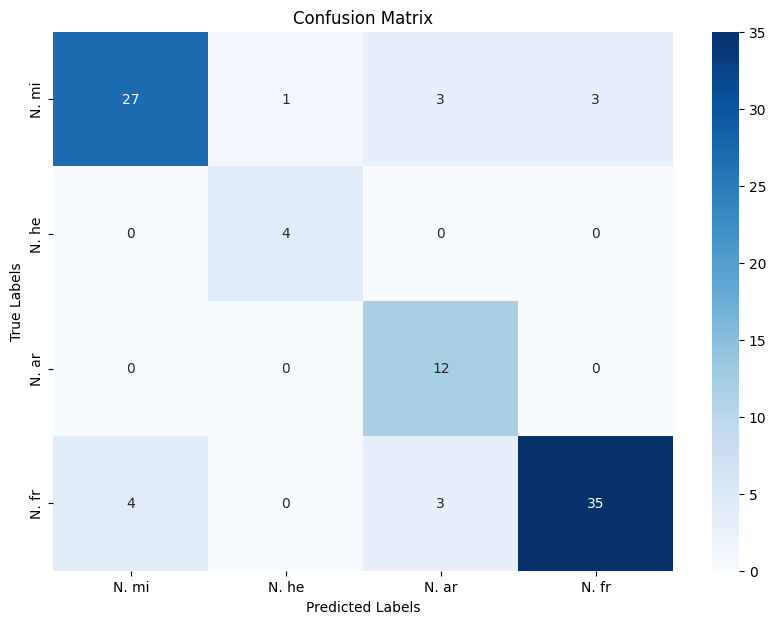

In [19]:
cm = confusion_matrix(all_labels, all_preds)

species_names = ['N. mi', 'N. he', 'N. ar', 'N. fr']  # Adjust these based on your dataset labels

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=species_names, yticklabels=species_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Model metrics

In [30]:
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {accuracy*100:.2f}%')

Overall Accuracy: 84.78%


In [32]:
# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3])
recall = recall_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3])

# Print precision and recall for each species (0.7 and up are good)
for i, species in enumerate(species_names):
    print(f"{species}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

N. mi: Precision = 0.87, Recall = 0.79
N. he: Precision = 0.80, Recall = 1.00
N. ar: Precision = 0.67, Recall = 1.00
N. fr: Precision = 0.92, Recall = 0.83


In [35]:
# Calculate F1 score for each class
f1_scores = f1_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3])

# Print F1 score for each species
for i, species in enumerate(species_names):
    print(f"{species}: F1 Score = {f1_scores[i]:.2f}")

# 0.7 - 0.9: Very Good - F1 scores in this range are considered very good, indicating that the model performs well at balancing false positives and false negatives. Models in this range are likely to be very effective for their intended application.    

N. mi: F1 Score = 0.83
N. he: F1 Score = 0.89
N. ar: F1 Score = 0.80
N. fr: F1 Score = 0.88


## Pseudo-Augmentation (ala Jeremy Howard)

In [ ]:
import shutil
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:

def copy_dataset(src, dst):
    if os.path.exists(dst):
        shutil.rmtree(dst)  # Remove the destination dir if it already exists
    shutil.copytree(src, dst)

source_dir = 'images/train_test_validate'
destination_dir = 'images/augmented_train_test_validate'

copy_dataset(source_dir, destination_dir)


# Define your transformations for augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),  # Randomly crop images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),  # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply only resize and normalization for validation and test sets
test_val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(root=f'{destination_dir}/train', transform=train_transforms)
validate_dataset = datasets.ImageFolder(root=f'{destination_dir}/validate', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root=f'{destination_dir}/test', transform=test_val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
import os
import shutil
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [46]:
def copy_dataset(src, dst):
    if os.path.exists(dst):
        shutil.rmtree(dst)  # Remove the destination dir if it already exists
    shutil.copytree(src, dst)

source_dir = '../data/images/train_test_validate'
destination_dir = '../data/images/augmented_train_test_validate'

copy_dataset(source_dir, destination_dir)

# Define your transformations for augmentation
save_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),  # Randomly crop images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),  # Randomly rotate images by up to 15 degrees
    # No need for ToTensor or Normalize here since we're saving images directly
])

def augment_images(directory, transform, copies=3):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                path = os.path.join(root, file)
                image = Image.open(path)
                for i in range(copies):  # Generate 'copies' number of augmented images
                    # Apply the transformation
                    augmented_image = transform(image)
                    # Save the augmented image
                    save_path = os.path.join(root, f"aug_{i}_{file}")
                    augmented_image.save(save_path)

# Apply the augmentation to the training directory only
augment_images(os.path.join(destination_dir, 'train'), save_train_transforms, copies=3)  # Aim to quadruple the dataset size

# Define transformations for loading images into PyTorch, including normalization
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply only resize and normalization for validation and test sets
test_val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the augmented datasets
train_dataset = datasets.ImageFolder(root=f'{destination_dir}/train', transform=train_transforms)
validate_dataset = datasets.ImageFolder(root=f'{destination_dir}/validation', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root=f'{destination_dir}/test', transform=test_val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
class ButterflyCNN(nn.Module):
    def __init__(self):
        super(ButterflyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Third convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 4)  # Second fully connected layer to output the class scores

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [49]:
model = ButterflyCNN()

# If a GPU is available, move the model to GPU
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # You can adjust this based on your observation of training performance

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the appropriate device
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

Epoch 1, Loss: 1.0420068913214915
Epoch 2, Loss: 0.5989861899131054


In [ ]:
# Collect all the predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

species_names = ['N. mi', 'N. he', 'N. ar', 'N. fr']  # Adjust these based on your dataset labels

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=species_names, yticklabels=species_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {accuracy*100:.2f}%')

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3])
recall = recall_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3])

# Print precision and recall for each species (0.7 and up are good)
for i, species in enumerate(species_names):
    print(f"{species}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

# Calculate F1 score for each class
f1_scores = f1_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3])

# Print F1 score for each species
for i, species in enumerate(species_names):
    print(f"{species}: F1 Score = {f1_scores[i]:.2f}")    